In [1]:
# imports
import pandas as pd
import numpy as np
import sqlalchemy
from sqlalchemy import create_engine
from datetime import datetime
import matplotlib.pyplot as plt



In [2]:
# load CSVs
providers = pd.read_csv('providers_data.csv')
receivers = pd.read_csv('receivers_data.csv')
food = pd.read_csv('food_listings_data.csv')
claims = pd.read_csv('claims_data.csv')

# quick preview
print('providers', providers.shape)
print('receivers', receivers.shape)
print('food', food.shape)
print('claims', claims.shape)

providers.head()

providers (1000, 6)
receivers (1000, 5)
food (1000, 9)
claims (1000, 5)


,Provider_ID,Name,Type,Address,City,Contact
0,1,Gonzales-Cochran,Supermarket,"74347 Christopher Extensions\nAndreamouth, OK ...",New Jessica,+1-600-220-0480
1,2,"Nielsen, Johnson and Fuller",Grocery Store,"91228 Hanson Stream\nWelchtown, OR 27136",East Sheena,+1-925-283-8901x6297
2,3,Miller-Black,Supermarket,"561 Martinez Point Suite 507\nGuzmanchester, W...",Lake Jesusview,001-517-295-2206
3,4,"Clark, Prince and Williams",Grocery Store,"467 Bell Trail Suite 409\nPort Jesus, IA 61188",Mendezmouth,556.944.8935x401
4,5,Coleman-Farley,Grocery Store,"078 Matthew Creek Apt. 319\nSaraborough, MA 53978",Valentineside,193.714.6577


In [3]:
# standardize column names
def clean_cols(df):
    df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
    return df

providers = clean_cols(providers)
receivers = clean_cols(receivers)
food = clean_cols(food)
claims = clean_cols(claims)

# show columns
providers.columns, receivers.columns, food.columns, claims.columns

(Index(['provider_id', 'name', 'type', 'address', 'city', 'contact'], dtype='object'),
 Index(['receiver_id', 'name', 'type', 'city', 'contact'], dtype='object'),
 Index(['food_id', 'food_name', 'quantity', 'expiry_date', 'provider_id',
        'provider_type', 'location', 'food_type', 'meal_type'],
       dtype='object'),
 Index(['claim_id', 'food_id', 'receiver_id', 'status', 'timestamp'], dtype='object'))

In [4]:
# convert types & date parsing
# food.expiry_date -> datetime
food['expiry_date'] = pd.to_datetime(food['expiry_date'], errors='coerce')

# claims.timestamp -> datetime
if 'timestamp' in claims.columns:
    claims['timestamp'] = pd.to_datetime(claims['timestamp'], errors='coerce')

# convert ids to integers where applicable
for df, col in [(providers, 'provider_id'), (receivers, 'receiver_id'),
                (food, 'food_id'), (claims, 'claim_id')]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

In [5]:
# basic cleaning functions
def clean_phone(x):
    if pd.isna(x): return x
    s = str(x)
    digits = ''.join([c for c in s if c.isdigit()])
    if len(digits) >= 10:
        return digits[-10:]   # keep last 10 digits (local number)
    return digits

if 'contact' in providers.columns:
    providers['contact'] = providers['contact'].apply(clean_phone)

if 'contact' in receivers.columns:
    receivers['contact'] = receivers['contact'].apply(clean_phone)

In [6]:
 # remove duplicates and invalid rows
providers = providers.drop_duplicates(subset=['provider_id']).reset_index(drop=True)
receivers = receivers.drop_duplicates(subset=['receiver_id']).reset_index(drop=True)
food = food.drop_duplicates(subset=['food_id']).reset_index(drop=True)
claims = claims.drop_duplicates(subset=['claim_id']).reset_index(drop=True)

In [7]:
# drop food rows without provider_id or quantity
food = food[food['provider_id'].notna() & food['quantity'].notna()]

In [8]:
# FK checks
missing_providers = set(food['provider_id'].dropna().unique()) - set(providers['provider_id'].dropna().unique())
missing_providers

set()

In [9]:
providers.isnull().sum()

provider_id    0
name           0
type           0
address        0
city           0
contact        0
dtype: int64

In [10]:
providers.isna().sum()

provider_id    0
name           0
type           0
address        0
city           0
contact        0
dtype: int64

In [11]:
receivers.isnull().sum()

receiver_id    0
name           0
type           0
city           0
contact        0
dtype: int64

In [12]:
food.isnull().sum()

food_id          0
food_name        0
quantity         0
expiry_date      0
provider_id      0
provider_type    0
location         0
food_type        0
meal_type        0
dtype: int64

In [13]:
claims.isnull().sum()

claim_id       0
food_id        0
receiver_id    0
status         0
timestamp      0
dtype: int64

In [14]:
# create engine and write to sqlite
engine = create_engine('sqlite:///data/food_waste.db', echo=False)


In [15]:
# write cleaned dataframes to SQL
providers.to_sql('providers', engine, if_exists='replace', index=False)
receivers.to_sql('receivers', engine, if_exists='replace', index=False)
food.to_sql('food_listings', engine, if_exists='replace', index=False)
claims.to_sql('claims', engine, if_exists='replace', index=False)

print("Wrote tables to data/food_waste.db")

Wrote tables to data/food_waste.db


In [16]:
# basic stats
print("Total providers:", len(providers))
print("Total receivers:", len(receivers))
print("Total food listings:", len(food))
print("Total claims:", len(claims))

Total providers: 1000
Total receivers: 1000
Total food listings: 1000
Total claims: 1000


In [17]:
# expired items
food['is_expired'] = (food['expiry_date'] < pd.Timestamp.now())
print("Expired listings:", food['is_expired'].sum())

Expired listings: 1000


In [18]:
# top food types
food['food_type'].value_counts().head(10)

food_type
Vegetarian        336
Vegan             334
Non-Vegetarian    330
Name: count, dtype: int64

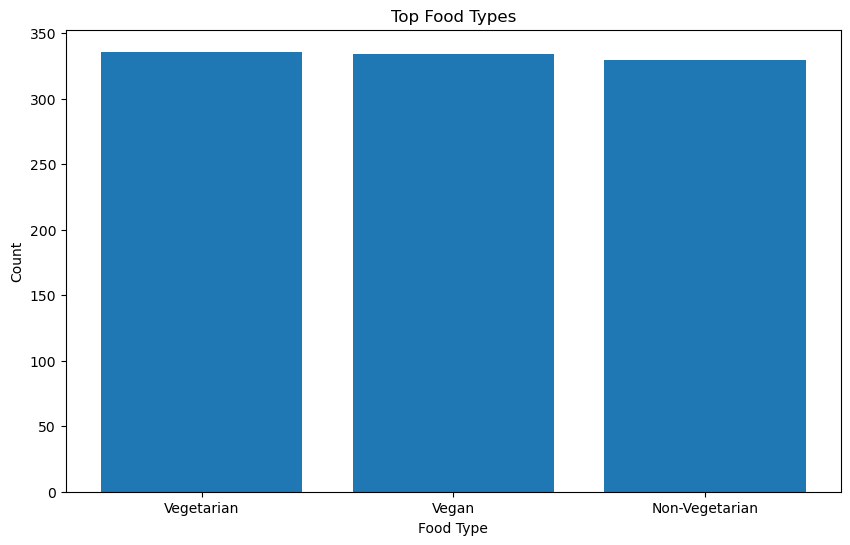

In [19]:
# import plotly.express as px

# top_food_types = food['food_type'].value_counts().reset_index().rename(columns={'index':'food_type','food_type':'count'})
# fig = px.bar(top_food_types, x='food_type', y='count', title='Top Food Types')
# fig.show()
top_food_types = food['food_type'].value_counts().reset_index()
top_food_types.columns = ['food_type', 'count']

# Step 2: Create the bar chart using Matplotlib
plt.figure(figsize=(10, 6))  # Optional: sets the figure size
plt.bar(top_food_types['food_type'], top_food_types['count'])
plt.title('Top Food Types')
plt.xlabel('Food Type')
plt.ylabel('Count')

plt.show()


In [20]:
# helper to run query
def run(q):
    return pd.read_sql_query(q, engine)

In [21]:
# Query 1: providers count per city
# How many food providers are there in each city?
q1 = """
SELECT city, COUNT(*) AS num_providers
FROM providers
GROUP BY city
ORDER BY num_providers DESC;
"""
run(q1)

,city,num_providers
0,South Christopherborough,3
1,New Carol,3
2,Williamview,2
3,West Lauraborough,2
4,West Christopher,2
...,...,...
958,Alexanderchester,1
959,Aguirreville,1
960,Adamsville,1
961,Adamsview,1


In [22]:
# -- receivers per city
# How many food receivers are there in each city?

q2= """SELECT city, COUNT(*) AS num_receivers
FROM receivers
GROUP BY city
ORDER BY num_receivers DESC;
"""
run(q2)

,city,num_receivers
0,New Christopher,3
1,Williamsfort,2
2,West Richard,2
3,West James,2
4,Stevenmouth,2
...,...,...
961,Alexanderbury,1
962,Aguilarstad,1
963,Aguilarbury,1
964,Adamland,1


In [23]:
# Which type of food provider contributes the most food?
q3="""SELECT p.type AS provider_type,
       SUM(f.quantity) AS total_quantity
FROM food_listings f
JOIN providers p ON f.provider_id = p.provider_id
GROUP BY p.type
ORDER BY total_quantity DESC;"""
run(q3)

,provider_type,total_quantity
0,Restaurant,6923
1,Supermarket,6696
2,Catering Service,6116
3,Grocery Store,6059


In [24]:
# Contact info of food providers in a specific city- Anitashire
q4 = """
SELECT name, contact, address
FROM providers
WHERE LOWER(TRIM(city)) = 'anitashire';

"""
run(q4)

,name,contact,address
0,Gutierrez-Palmer,9278322085,"019 Avila Station\nLake Dennisborough, AZ 84988"


In [25]:
# Which receivers have claimed the most food?
q5="""
SELECT r.receiver_id, r.name, COUNT(c.claim_id) AS claims_count
FROM claims c
JOIN receivers r ON c.receiver_id = r.receiver_id
GROUP BY r.receiver_id, r.name
ORDER BY claims_count DESC
LIMIT 20;
"""
run(q5)

,receiver_id,name,claims_count
0,276,Scott Hunter,5
1,371,William Frederick,5
2,742,Matthew Webb,5
3,800,Anthony Garcia,5
4,90,Alvin West,4
5,144,Jennifer Nelson,4
6,301,Kristina Simpson,4
7,324,Kristine Martin,4
8,410,Betty Reid,4
9,493,Chelsea Powell,4


In [26]:
# Total quantity of food available from all providers
q6="""
SELECT SUM(quantity) AS total_available_quantity
FROM food_listings;
"""
run(q6)

,total_available_quantity
0,25794


In [27]:
# Which city has highest number of food listings
q7="""
SELECT location AS city, COUNT(*) AS listings_count
FROM food_listings
GROUP BY location
ORDER BY listings_count DESC
LIMIT 10;
"""
run(q7)

,city,listings_count
0,South Kathryn,6
1,New Carol,6
2,Perezport,5
3,Jimmyberg,5
4,East Angela,5
5,West Whitneymouth,4
6,West Kevin,4
7,South Thomasville,4
8,South Christopherborough,4
9,Port Patrick,4


In [28]:
# Most commonly available food types
q8="""
SELECT food_type, COUNT(*) AS cnt
FROM food_listings
GROUP BY food_type
ORDER BY cnt DESC
LIMIT 10;
"""
run(q8)

,food_type,cnt
0,Vegetarian,336
1,Vegan,334
2,Non-Vegetarian,330


In [29]:
# How many food claims have been made for each food item
q9="""
SELECT f.food_id, f.food_name, COUNT(c.claim_id) AS claim_count
FROM food_listings f
LEFT JOIN claims c ON f.food_id = c.food_id
GROUP BY f.food_id, f.food_name
ORDER BY claim_count DESC;
"""
run(q9)

,food_id,food_name,claim_count
0,463,Soup,5
1,486,Chicken,5
2,548,Fish,5
3,35,Rice,4
4,92,Chicken,4
...,...,...,...
995,987,Dairy,0
996,993,Soup,0
997,994,Salad,0
998,996,Fish,0


In [30]:
# Which provider has had the highest number of successful food claims
q10="""
SELECT p.provider_id, p.name, COUNT(c.claim_id) AS completed_claims
FROM claims c
JOIN food_listings f ON c.food_id = f.food_id
JOIN providers p ON f.provider_id = p.provider_id
WHERE LOWER(c.status) = 'completed'
GROUP BY p.provider_id, p.name
ORDER BY completed_claims DESC
LIMIT 10;
"""

run(q10)

,provider_id,name,completed_claims
0,709,Barry Group,5
1,241,"Harper, Blake and Alexander",4
2,596,"Barnes, Castro and Curtis",4
3,752,Butler-Richardson,4
4,967,Miller Inc,4
5,161,Campbell LLC,3
6,262,Bradford-Martinez,3
7,315,Nelson LLC,3
8,384,Rogers-Warren,3
9,538,Beck Inc,3


In [31]:
# What percentage of claims are completed vs pending vs cancelled
q11="""
SELECT status, COUNT(*) AS cnt,
       ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM claims), 2) AS pct
FROM claims
GROUP BY status;
"""
run(q11)

,status,cnt,pct
0,Cancelled,336,33.6
1,Completed,339,33.9
2,Pending,325,32.5


In [32]:
# Average quantity of food claimed per receiver
q12="""
SELECT r.receiver_id, r.name, ROUND(AVG(f.quantity),2) AS avg_quantity_per_claim
FROM claims c
JOIN food_listings f ON c.food_id = f.food_id
JOIN receivers r ON c.receiver_id = r.receiver_id
GROUP BY r.receiver_id, r.name
ORDER BY avg_quantity_per_claim DESC
LIMIT 20;
"""
run(q12)

,receiver_id,name,avg_quantity_per_claim
0,99,Nancy Silva,50.0
1,282,Lisa Pitts,50.0
2,429,Daniel Williams,50.0
3,567,Peggy Knight,50.0
4,616,Christopher Wright,50.0
5,739,Nancy Jones,50.0
6,982,Thomas Villanueva,50.0
7,37,Angel Adams,49.0
8,38,Alexander Mullins,49.0
9,69,Scott Brown,49.0


In [33]:
# Which meal type is claimed the most
q13="""
SELECT f.meal_type, COUNT(c.claim_id) AS times_claimed
FROM claims c
JOIN food_listings f ON c.food_id = f.food_id
GROUP BY f.meal_type
ORDER BY times_claimed DESC;
"""
run(q13)

,meal_type,times_claimed
0,Breakfast,278
1,Lunch,250
2,Snacks,240
3,Dinner,232


In [34]:
# Total quantity donated by each provider
q14="""
SELECT p.provider_id, p.name, SUM(f.quantity) AS total_donated
FROM food_listings f
JOIN providers p ON f.provider_id = p.provider_id
GROUP BY p.provider_id, p.name
ORDER BY total_donated DESC
LIMIT 20;
"""
run(q14)

,provider_id,name,total_donated
0,709,Barry Group,179
1,306,"Evans, Wright and Mitchell",158
2,655,Smith Group,150
3,315,Nelson LLC,142
4,678,Ruiz-Oneal,140
5,499,Blankenship-Lewis,124
6,41,Kelly-Ware,123
7,161,Campbell LLC,123
8,262,Bradford-Martinez,121
9,146,Hampton-Lee,116


In [35]:
# Claims per day (time series)
q15="""
SELECT DATE(timestamp) AS day, COUNT(*) AS claims_count
FROM claims
GROUP BY day
ORDER BY day;
"""
run(q15)

,day,claims_count
0,2025-03-01,40
1,2025-03-02,47
2,2025-03-03,46
3,2025-03-04,44
4,2025-03-05,47
5,2025-03-06,37
6,2025-03-07,53
7,2025-03-08,56
8,2025-03-09,40
9,2025-03-10,60


In [36]:
# Distribution efficiency: % of provider's listings that were completed (per provider)
q16="""
WITH provider_listings AS (
  SELECT provider_id, COUNT(*) AS total_listings
  FROM food_listings
  GROUP BY provider_id
), provider_completed AS (
  SELECT f.provider_id, COUNT(c.claim_id) AS completed_claims
  FROM claims c
  JOIN food_listings f ON c.food_id = f.food_id
  WHERE LOWER(c.status) = 'completed'
  GROUP BY f.provider_id
)
SELECT pr.provider_id, pr.name,
       COALESCE(pc.completed_claims,0) AS completed_claims,
       pl.total_listings,
       ROUND(100.0 * COALESCE(pc.completed_claims,0) / pl.total_listings,2) AS pct_completed
FROM provider_listings pl
JOIN providers pr ON pl.provider_id = pr.provider_id
LEFT JOIN provider_completed pc ON pl.provider_id = pc.provider_id
ORDER BY pct_completed DESC
LIMIT 20;
"""
run(q16)


,provider_id,name,completed_claims,total_listings,pct_completed
0,916,Davis and Sons,3,1,300.0
1,55,Wilson-Brown,2,1,200.0
2,82,Carey-Richardson,2,1,200.0
3,84,Atkins Group,2,1,200.0
4,104,Jackson LLC,2,1,200.0
5,110,Figueroa-Soto,2,1,200.0
6,202,Graham-Peters,2,1,200.0
7,227,Morse-Hoffman,2,1,200.0
8,252,Blair LLC,2,1,200.0
9,270,Harrison-Wilson,2,1,200.0


In [37]:
pd.read_sql_query("PRAGMA table_info(receivers);", engine)


,cid,name,type,notnull,dflt_value,pk
0,0,receiver_id,BIGINT,0,None,0
1,1,name,TEXT,0,None,0
2,2,type,TEXT,0,None,0
3,3,city,TEXT,0,None,0
4,4,contact,TEXT,0,None,0
